In [1]:
%load_ext autoreload
%autoreload 2

from pathlib import Path
import _pickle as pickle
import torch
from torch.utils.data import DataLoader
from pydub import AudioSegment

from train import load_hparams, load_model, load_checkpoint, make_aug_param_dictionary
from model import CnnEncoder
from data_utils import WindowedContourSet, ContourCollate, HummingPairSet
from loss_function import SiameseLoss
from validation import get_contour_embeddings, cal_ndcg_single
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import IPython.display as ipd
import soundfile
import random


def normalized_vec_to_orig(norm_contour, mean_pitch=69, std=5.5201786930065415):
    orig = np.zeros_like(norm_contour[:,0])
    orig[norm_contour[:,1]==1] = 440 * 2 ** ((norm_contour[norm_contour[:,1]==1, 0] * std + mean_pitch -69) / 12)
#     orig[norm_contour==-100] = 0
    return orig


def generate_sine_wav(melody, frame_rate=10, sr=44100):
    melody_resampled = np.repeat(melody, sr//frame_rate)
    phi = np.zeros_like(melody_resampled)
    phi[1:] = np.cumsum(2* np.pi * melody_resampled[:-1] / sr, axis=0)
    sin_wav = 0.6 * np.sin(phi)
    return sin_wav

def load_orig_audio_by_id(track_id, audio_path=Path('/home/svcapp/userdata/flo_data_backup/')):
    orig_audio_path = audio_path / track_id[:3] / track_id[3:6] / (track_id +'.aac')
    if not orig_audio_path.exists():
        orig_audio_path = orig_audio_path.with_suffix('.m4a')
    if not orig_audio_path.exists():
        orig_audio_path = audio_path / 'qbh' / (track_id + '.aac')
    orig_song = AudioSegment.from_file(orig_audio_path, 'm4a').set_channels(1)._data
    orig_decoded = np.frombuffer(orig_song, dtype=np.int16) / 32768 
    return orig_decoded

In [2]:
# Load model

# model_path = Path('/home/svcapp/t2meta/qbh_model/worker_345004_contour_scheduled_hidden256_lr0.0001_210201-004246/')
model_path = Path('/home/svcapp/userdata/flo_model/worker_480799_contour_scheduled_hidden256_lr0.0001_210305-094909/')
hparams = load_hparams(model_path / 'hparams.dat')
model = CnnEncoder(hparams).cuda()
model, _, _, _ = load_checkpoint(model_path/'checkpoint_best.pt', model, None, train_on_humming=True)


criterion = SiameseLoss(margin=hparams.loss_margin, use_euclid=hparams.use_euclid)


Loading checkpoint '/home/svcapp/userdata/flo_model/worker_480799_contour_scheduled_hidden256_lr0.0001_210305-094909/checkpoint_best.pt'
Loaded checkpoint '/home/svcapp/userdata/flo_model/worker_480799_contour_scheduled_hidden256_lr0.0001_210305-094909/checkpoint_best.pt' from iteration 1000001


In [3]:
sum(p.numel() for p in model.parameters())

5894144

In [4]:
# Load data

# with open(hparams.contour_path, 'rb') as f:
# with open('/home/svcapp/t2meta/flo_melody/overlapped.dat', 'rb') as f:
with open('/home/svcapp/userdata/flo_melody/overlapped.dat', 'rb') as f:
    pre_loaded_data = pickle.load(f)
    

In [6]:
len(set([x['song_id'] for x in pre_loaded_data]))

5955

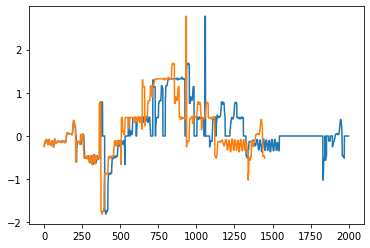

In [87]:
idx = 1800
plt.plot(pre_loaded_data[idx]['contour'][:,0])
plt.plot(pre_loaded_data[idx]['contour'][pre_loaded_data[idx]['contour'][:,1]==1,0])

In [128]:
def cal_instability_of_contour(contour):
#     dummy = np.copy(contour)
    non_zero_pitch = contour[contour[:,1]==1,0]
    return np.std(np.diff(non_zero_pitch))

# idx = 100
# plt.plot(pre_loaded_data[idx]['contour'][:,0])
for i in range(0,5000,100):
    print(i, cal_instability_of_contour(pre_loaded_data[i]['contour']))


0 0.10591353052635284
100 0.11724397627067812
200 0.09015640921079933
300 0.12259398943880076
400 0.20153044627906413
500 0.09231201097180516
600 0.10647396303922876
700 0.1003143829492145
800 0.08488501418990298
900 0.08252153886873953
1000 0.07494656886774172
1100 0.19326695938439156
1200 0.09484352273327848
1300 0.07659268813804783
1400 0.0892525036659188
1500 0.07603375224268538
1600 0.12013389074399888
1700 0.11274093924568013
1800 0.14747990361415592
1900 0.07280622281110274
2000 0.12266910073972144
2100 0.08595961202610836
2200 0.06942123532561853
2300 0.13251717361100096
2400 0.06349162797436131
2500 0.08192042463863503
2600 0.1651720558029014
2700 0.11205525781309272
2800 0.12051602310495885
2900 0.08452542286380428
3000 0.09749144684663462
3100 0.11545769456710481
3200 0.12123085596375725
3300 0.10750419729010384
3400 0.09944844094539987
3500 0.08944572935850313
3600 0.13441678331508458
3700 0.08766091539389231
3800 0.11055413795100699
3900 0.07772646789459767
4000 0.11299828

In [10]:
aug_weights = make_aug_param_dictionary(hparams)
trainset = WindowedContourSet(hparams.data_dir,  aug_weights, set_type='train', pre_load=True, pre_load_data=pre_loaded_data, num_aug_samples=hparams.num_pos_samples, num_neg_samples=hparams.num_neg_samples, min_aug=10)
validset =  WindowedContourSet(hparams.data_dir, aug_weights, set_type='valid', pre_load=True, pre_load_data=pre_loaded_data, num_aug_samples=4, num_neg_samples=0, min_aug=10)
entireset = WindowedContourSet(hparams.data_dir, [], set_type='entire', pre_load=True,pre_load_data=pre_loaded_data, num_aug_samples=0, num_neg_samples=0)

train_loader = DataLoader(trainset, 64, shuffle=True,num_workers=2,
    collate_fn=ContourCollate(hparams.num_pos_samples, hparams.num_neg_samples, for_cnn=True), pin_memory=False)
valid_loader = DataLoader(validset, 512, shuffle=True,num_workers=hparams.num_workers,
    collate_fn=ContourCollate(hparams.num_pos_samples, 0, for_cnn=True), pin_memory=False, drop_last=False)
entire_loader = DataLoader(entireset, 512, shuffle=True,num_workers=hparams.num_workers,
    collate_fn=ContourCollate(0, 0, for_cnn=True), pin_memory=False, drop_last=False)


# with open(hparams.humming_path, "rb") as f:
with open('/home/svcapp/userdata/flo_melody/humming_db_contour_pairs.dat', 'rb') as f:
    contour_pairs = pickle.load(f)

humm_train_set = HummingPairSet(contour_pairs, aug_weights, "train", [], num_aug_samples=hparams.num_pos_samples, num_neg_samples=hparams.num_neg_samples)
humm_train_loader = DataLoader(humm_train_set, 64, shuffle=True,num_workers=hparams.num_workers,
    collate_fn=ContourCollate(hparams.num_pos_samples, hparams.num_neg_samples, for_cnn=True), pin_memory=False)
humm_valid_set = HummingPairSet(contour_pairs, [], "valid",[], num_aug_samples=0, num_neg_samples=0)
humm_valid_loader = DataLoader(humm_valid_set, hparams.valid_batch_size, shuffle=False,num_workers=hparams.num_workers,
    collate_fn=ContourCollate(0, 0, for_cnn=True), pin_memory=True, drop_last=False)
humm_test_set = HummingPairSet(contour_pairs, [], "test",[], num_aug_samples=0, num_neg_samples=0)
humm_test_loader = DataLoader(humm_test_set, 1, shuffle=False,num_workers=hparams.num_workers,
    collate_fn=ContourCollate(0, 0, for_cnn=True), pin_memory=True, drop_last=False)

In [141]:
batch = next(iter(train_loader))
model.eval()
with torch.no_grad():
    batch = batch.cuda()
    anchor, pos, neg = model.siamese(batch)
    loss = criterion(anchor, pos, neg, return_item=True)
    
humm_batch = next(iter(humm_train_loader))
with torch.no_grad():
    humm_batch = humm_batch.cuda()
    humm_anchor, humm_pos, humm_neg = model.siamese(humm_batch)
    loss = criterion(anchor, pos, neg, return_item=True)
    
valid_batch = next(iter(valid_loader))
with torch.no_grad():
    valid_batch = valid_batch[0].cuda()
    valid_emb = model(valid_batch)

Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f2bda7ca400>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1101, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1075, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 124, in join
    res = self._popen.wait(timeout)
  File "/usr/lib/python3.6/multiprocessing/popen_fork.py", line 47, in wait
    if not wait([self.sentinel], timeout):
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 911, in wait
    ready = selector.select(timeout)
  File "/usr/lib/python3.6/selectors.py", line 376, in select
    fd_event_list = self._poll.poll(timeout)
KeyboardInterrupt: 


KeyboardInterrupt: 

In [11]:
total_embs, total_song_ids = get_contour_embeddings(model, entire_loader)

IndexError: tuple index out of range

In [ ]:
valid_score = 0
total_ndcg = []
total_recommends = []
with torch.no_grad():
    for j, batch in enumerate(humm_valid_loader):
#         batch = next(iter(humm_valid_loader))
        contours, song_ids = batch
        contours[contours[:,:,0]>3,:] = 0
        anchor = model(contours.cuda())
        anchor_norm = anchor / anchor.norm(dim=1)[:, None]
        similarity = torch.mm(anchor_norm, total_embs.transpose(0,1))
        recommends = torch.topk(similarity, k=hparams.num_recom, dim=-1)[1]
        
        top_recommends = recommends[:,0].tolist()
        for rec in top_recommends:
            total_recommends.append( entire_loader.dataset.contours[rec])
        entire_loader.dataset.contours
        recommends = total_song_ids[recommends]
        ndcg = [cal_ndcg_single(recommends[i,:], song_ids[i]) for i in range(recommends.shape[0])]
        total_ndcg += ndcg
        ndcg = sum(ndcg) / len(ndcg)
        valid_score += ndcg
valid_score = valid_score/(j+1)
print(valid_score)

In [142]:
model.eval()
num_correct_answer = 0
total_success = []
total_recommends = []
total_test_ids = []
with torch.no_grad():
#     total_embs, total_song_ids = get_contour_embeddings(model, entire_loader)
    for j, batch in enumerate(humm_test_loader):
        contours, song_ids = batch
        anchor = model(contours.cuda())
        anchor_norm = anchor / anchor.norm(dim=1)[:, None]
        similarity = torch.mm(anchor_norm, total_embs.transpose(0,1))
        recommends = torch.topk(similarity, k=30, dim=-1)[1]
        top_recommends = recommends[:,0].tolist()
        for rec in top_recommends:
            total_recommends.append( entire_loader.dataset.contours[rec])
        recommends = total_song_ids[recommends]
        top10_success = [ int(int(song_ids[i]) in recommends[i,:10].tolist()) for i in range(recommends.shape[0])]
        total_success += top10_success
        total_recommends.append(recommends)
        total_test_ids.append(song_ids)
        
        num_correct_answer += sum(top10_success)
print(num_correct_answer / len(humm_test_loader.dataset))
# total_recommends = torch.cat(total_recommends, dim=0).cpu().numpy()
total_test_ids = torch.cat(total_test_ids, dim=0).cpu().numpy()

0.556


In [193]:
import time
from sampling_utils import downsample_contour, downsample_contour_array

with torch.no_grad():
#     total_embs, total_song_ids = get_contour_embeddings(model, entire_loader)
    time_a = time.time()
#     batch = next(iter(humm_test_loader))
    contours = torch.Tensor(downsample_contour_array(humm_test_loader.dataset.contours[0]['humm'])).unsqueeze(0)
    song_ids = torch.LongTensor([humm_test_loader.dataset.contours[0]['meta']['track_id']]).unsqueeze(0)
    print(contours.shape, song_ids.shape)
#     contours, song_ids = batch
    anchor = model(contours.cuda())
    anchor_norm = anchor / anchor.norm(dim=1)[:, None]
    similarity = torch.mm(anchor_norm, total_embs.transpose(0,1))
    recommends = torch.topk(similarity, k=30, dim=-1)[1]
    top_recommends = recommends[:,0].tolist()
    for rec in top_recommends:
        total_recommends.append( entire_loader.dataset.contours[rec])
    recommends = total_song_ids[recommends]
    top10_success = [ int(int(song_ids[i]) in recommends[i,:10].tolist()) for i in range(recommends.shape[0])]
#     total_success += top10_success
#     total_recommends.append(recommends)
#     total_test_ids.append(song_ids)
    print(time.time() - time_a)

torch.Size([1, 212, 2]) torch.Size([1, 1])
0.00682830810546875


In [166]:
# freeze_norm = anchor / anchor.norm(dim=1)[:, None]
# freeze_norm = freeze_norm.cpu().numpy()
len(set(x['song_id'] for x in trainset.contours))

4967

In [82]:
anchor_norm[0]

tensor([-7.9779e-02, -3.3523e-02,  8.5986e-02, -7.6535e-03, -5.0430e-03,
         6.8724e-02,  4.6679e-02,  8.3047e-03, -3.6751e-04, -2.9534e-02,
        -1.2359e-02,  2.9862e-03, -1.4075e-01,  1.1855e-02,  8.9761e-03,
        -3.0739e-02,  7.4264e-03, -7.0718e-03,  4.1864e-03, -5.7551e-02,
        -1.5466e-02, -3.9010e-02,  5.4103e-02, -3.0627e-02,  9.0589e-03,
         2.0963e-03,  1.6070e-02, -9.3673e-03, -3.7519e-03, -3.5495e-03,
         1.4603e-02, -2.6597e-02, -9.1618e-03,  4.6076e-03, -3.0176e-04,
         6.1563e-02, -1.4180e-03, -3.8969e-02,  2.3581e-02, -3.7549e-02,
        -1.0107e-02,  2.3203e-02, -4.7533e-02,  7.8232e-02,  5.3198e-04,
        -3.7091e-02,  9.8126e-03,  2.8466e-02,  1.4382e-02, -9.5805e-02,
        -4.9572e-03,  5.7959e-02,  8.2649e-02, -1.6813e-01, -2.8509e-02,
         2.4474e-02,  1.3457e-02, -6.0954e-02, -5.3502e-03,  2.2779e-02,
        -6.9772e-02,  6.0916e-03, -1.5949e-01,  5.0030e-03,  1.9176e-02,
        -1.4504e-02, -5.7300e-03,  9.2045e-02, -8.8

In [104]:
score_by_k = []
num_correct_by_k = []
for k in range(30):
    top_k_success = [ int(int(total_test_ids[i]) in total_recommends[i,:k].tolist()) for i in range(total_recommends.shape[0])]
    score_by_k.append(sum(top_k_success)/len(top_k_success))
    accuracy_by_meta = defaultdict(list)
    for i in range(total_recommends.shape[0]):
        accuracy_by_meta[int(total_test_ids[i])].append(int(int(total_test_ids[i]) in total_recommends[i,:k].tolist()))
    temp_histogram = [0,0,0,0,0,0]
    for value in accuracy_by_meta.values():
        temp_histogram[sum(value)] += 1
    num_correct_by_k.append(temp_histogram)

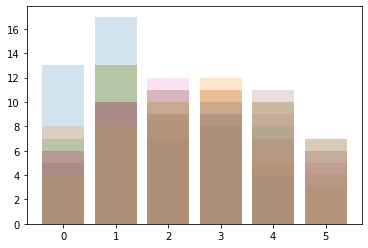

In [108]:
for i, score in enumerate(num_correct_by_k[1:10]):
    plt.bar([0,1,2,3,4,5], score, alpha=0.2)

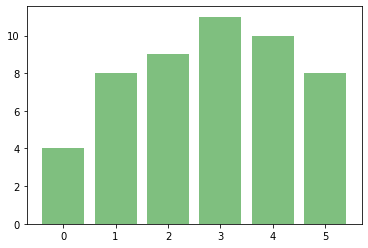

In [109]:
for i, score in enumerate(num_correct_by_k[10:11]):
    plt.bar([0,1,2,3,4,5], score, alpha=0.5, color='green')

<BarContainer object of 6 artists>

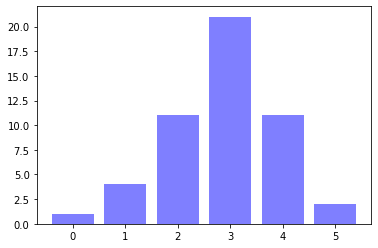

In [110]:
threshold = 0.55
histogram = [0,0,0,0,0,0]
for i in range(50):
    test = [int(random.random() < 0.55),int(random.random() < 0.55),int(random.random() < 0.55),int(random.random() < 0.55),int(random.random() < 0.55)]
    histogram[sum(test)] += 1

# plt.plot(histogram)
plt.bar([0,1,2,3,4,5], histogram, alpha=0.5, color='blue')  

In [93]:
0.55 ** 5

0.05032843750000002

In [177]:
len(set(x['song_id'] for x in entireset.contours))

5955

Text(0, 0.5, 'accuracy')

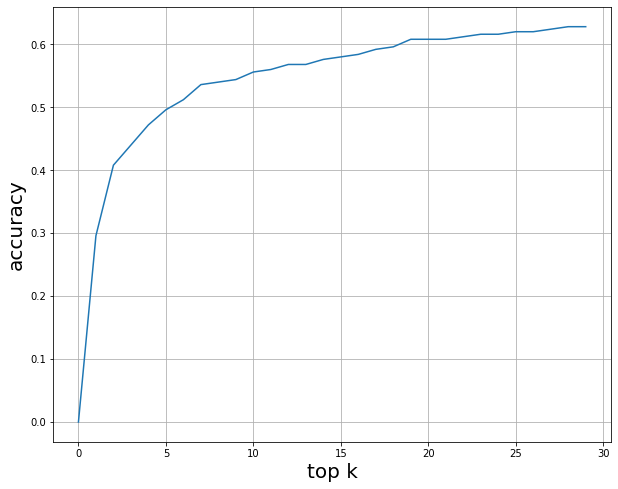

In [59]:
plt.figure(figsize=(10,8))
plt.plot(score_by_k)
plt.grid(True)
plt.xlabel("top k", fontsize=20)
plt.ylabel("accuracy", fontsize=20)

In [122]:
from humming_data_utils import load_meta_from_excel, HummingDB
selected_100, selected_900 = load_meta_from_excel()
humming_db = HummingDB('/home/svcapp/userdata/humming_db', '/home/svcapp/userdata/flo_data_backup/', selected_100, selected_900)


In [135]:
# for id in top_songs:
#     print(selected_100.loc[selected_100['track_id'] == id])


In [170]:
from collections import defaultdict

test_song_meta = [x['meta'] for x in humm_test_loader.dataset.contours]
accuracy_by_meta = defaultdict(list)
for score, meta in zip(total_success, test_song_meta):
    accuracy_by_meta[int(meta['track_id'])].append(score)
#     accuracy_by_meta[meta['singer_id']].append(score)
#     accuracy_by_meta[meta['singer_group']].append(score)
#     accuracy_by_meta[meta['humming_type']].append(score)
#     accuracy_by_meta[meta['singer_gender']].append(score)

In [153]:
accuracy_by_meta

defaultdict(list,
            {'KRJ': [0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1],
             'PSH': [1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1],
             'YDW': [1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1],
             'KHW': [1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0],
             'HCW': [1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0],
             'KJH': [0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1],
             'JJH': [1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1],
             'KSA': [0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0],
             'GHW': [0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1],
             'LYJ': [1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0],
             'YYS': [0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0],
             'NIK': [1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1],
             'KKR': [1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0],
             'KR0': [1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0],
             'OS0': [1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1],
             'DYJ': [1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1],
             'YJS': [1, 1, 0, 1, 1, 

In [121]:
test_song_meta[0]

{'path': '/home/svcapp/userdata/humming_db/100/0~24/01_P/100_11_C_151-169_(PF_KRJ).wav',
 'pitch_path': '/home/svcapp/userdata/humming_db/100/0~24/01_P/100_11_C_151-169_(PF_KRJ).f0.csv',
 'song_group': '100',
 'song_idx': '11',
 'humming_type': 'C',
 'time_stamp': '151-169',
 'singer_group': 'P',
 'singer_id': 'KRJ',
 'singer_gender': 'F',
 'track_id': 31484300}

In [171]:
top_songs = [x for x in accuracy_by_meta.keys() if sum(accuracy_by_meta[x])==1]
top_songs

[5466183, 421881404, 2114588, 420497440, 434425125, 263908, 420728289, 5244502]

In [62]:
for key in accuracy_by_meta:
    if isinstance(key, str):
        print(f'group {key} has total {len(accuracy_by_meta[key])} samples with correct answer {sum(accuracy_by_meta[key])}, in ratio {sum(accuracy_by_meta[key])/len(accuracy_by_meta[key])}')

group P has total 100 samples with correct answer 57, in ratio 0.57
group C has total 73 samples with correct answer 46, in ratio 0.6301369863013698
group F has total 125 samples with correct answer 74, in ratio 0.592
group A has total 60 samples with correct answer 29, in ratio 0.48333333333333334
group D has total 65 samples with correct answer 39, in ratio 0.6
group B has total 52 samples with correct answer 25, in ratio 0.4807692307692308
group N has total 150 samples with correct answer 82, in ratio 0.5466666666666666
group M has total 125 samples with correct answer 65, in ratio 0.52


(0.2, 0.65)

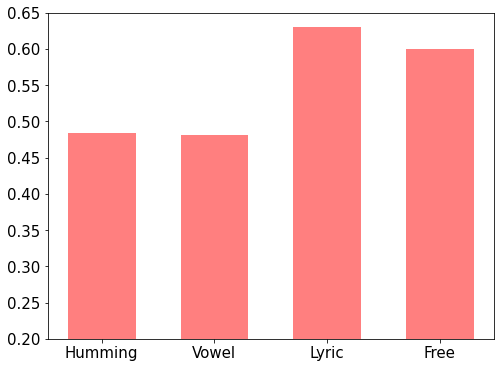

In [77]:
target_key = ["A","B","C","D"]
target_accuracy = []
for key in target_key:
    target_accuracy.append(sum(accuracy_by_meta[key])/len(accuracy_by_meta[key]))
target_accuracy

plt.figure(figsize=(8,6))
plt.bar(target_key, target_accuracy, color='red', alpha=0.5, width=0.6)
plt.xticks(target_key, ["Humming", "Vowel", "Lyric", "Free"], fontsize=15)
plt.yticks(fontsize=15)
plt.ylim([0.2,0.65])

(0.0, 0.9)

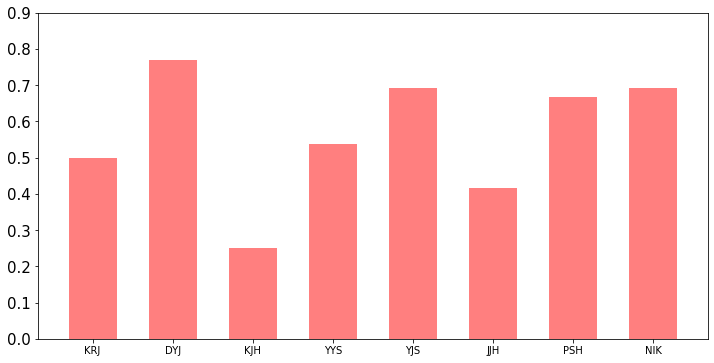

In [157]:
# target_key = accuracy_by_meta.keys()
target_key = ["KRJ", "DYJ", "KJH", "YYS", "YJS", "JJH", "PSH", "NIK"]
target_accuracy = []
for key in target_key:
    target_accuracy.append(sum(accuracy_by_meta[key])/len(accuracy_by_meta[key]))
target_accuracy

plt.figure(figsize=(12,6))
plt.bar(target_key, target_accuracy, color='red', alpha=0.5, width=0.6)
# plt.xticks(target_key, ["Humming", "Vowel", "Lyric", "Free"], fontsize=15)
plt.yticks(fontsize=15)
plt.ylim([0.,0.9])

(0.0, 0.9)

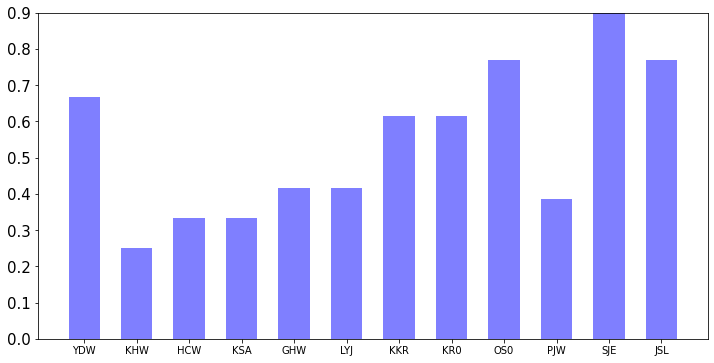

In [168]:
target_key = accuracy_by_meta.keys()
filter_key =  ["KRJ", "DYJ", "KJH", "YYS", "YJS", "JJH", "PSH", "NIK"]
target_key = [x for x in target_key if x not in filter_key]
target_accuracy = []
for key in target_key:
    target_accuracy.append(sum(accuracy_by_meta[key])/len(accuracy_by_meta[key]))
target_accuracy

plt.figure(figsize=(12,6))
plt.bar(target_key, target_accuracy, color='blue', alpha=0.5, width=0.6)
# plt.xticks(target_key, ["Humming", "Vowel", "Lyric", "Free"], fontsize=15)
plt.yticks(fontsize=15)
plt.ylim([0.,0.9])

In [167]:
low_performer_id = ["KHW", "HCW", "KSA", "KJH", "PJW", "JJH"]
pair_db = humm_test_loader.dataset.contours
from shutil import copyfile

for i, sample in enumerate(pair_db):
    if sample['meta']['singer_id'] in low_performer_id:
        sample = pair_db[i]
        humm_contour = sample['humm']
        orig_contour = sample['orig']
        humm_audio = generate_sine_wav(normalized_vec_to_orig(humm_contour), frame_rate=100)
        orig_contour_audio = generate_sine_wav(normalized_vec_to_orig(orig_contour), frame_rate=100)
        orig_audio = load_orig_audio_by_id(str(sample['meta']['track_id']))
        slice_pos = [int(x) for x in sample['meta']['time_stamp'].split('-')]
        orig_audio = orig_audio[slice_pos[0]*44100:slice_pos[1]*44100]
        
        top_rec = total_recommends[i]
        top_rec_contour_audio = generate_sine_wav(normalized_vec_to_orig(top_rec['contour']), frame_rate=100)
        top_rec_audio = load_orig_audio_by_id(str(top_rec['song_id']))
        top_rec_audio = top_rec_audio[top_rec['frame_pos'][0]*441:top_rec['frame_pos'][1]*441]
        
        fig = plt.figure(figsize=(15, 8))
        fig.tight_layout()
        plt.plot(humm_contour[:,0])
        plt.plot(orig_contour[:,0])
#         plt.plot(top_rec['contour'][:,0])
        path = Path(sample["meta"]["pitch_path"])
        plt.savefig(f'valid_monitoring/{path.stem}_plot.png')
        plt.close(fig)
        
        fig2 = plt.figure(figsize=(15, 8))
        fig2.tight_layout()
        plot_contour_with_voice_only(humm_contour)
        plot_contour_with_voice_only(orig_contour)
#         plot_contour_with_voice_only(top_rec['contour'])
        plt.savefig(f'valid_monitoring/{path.stem}_voice_only_plot.png')
        plt.close(fig2)
    
        copyfile(sample['meta']['path'], f'valid_monitoring/{Path(sample["meta"]["pitch_path"]).stem}_hum.wav')
        soundfile.write(f'valid_monitoring/{Path(sample["meta"]["pitch_path"]).stem}_humming.wav', humm_audio, 44100)
        soundfile.write(f'valid_monitoring/{Path(sample["meta"]["pitch_path"]).stem}_orig_contour.wav', orig_contour_audio, 44100)
        soundfile.write(f'valid_monitoring/{Path(sample["meta"]["pitch_path"]).stem}_orig.wav', orig_audio, 44100)
        soundfile.write(f'valid_monitoring/{Path(sample["meta"]["pitch_path"]).stem}_orig_combined.wav', (orig_audio+orig_contour_audio)/2, 44100)
        soundfile.write(f'valid_monitoring/{Path(sample["meta"]["pitch_path"]).stem}_top_rec_contour.wav', top_rec_contour_audio, 44100)
        soundfile.write(f'valid_monitoring/{Path(sample["meta"]["pitch_path"]).stem}_top_rec.wav', top_rec_audio, 44100)


IndexError: too many indices for tensor of dimension 2

(0.2, 0.65)

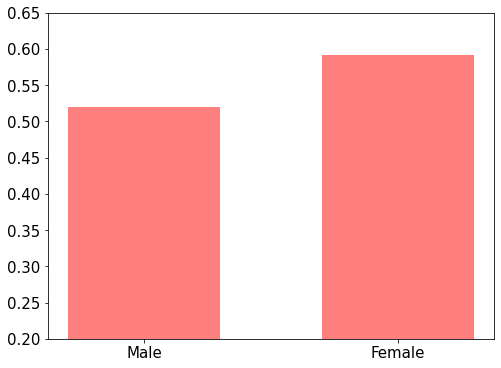

In [78]:
target_key = ["M","F"]
target_accuracy = []
for key in target_key:
    target_accuracy.append(sum(accuracy_by_meta[key])/len(accuracy_by_meta[key]))
target_accuracy

plt.figure(figsize=(8,6))
plt.bar(target_key, target_accuracy, color='red', alpha=0.5, width=0.6)
plt.xticks(target_key, ["Male", "Female"], fontsize=15)
plt.yticks(fontsize=15)
plt.ylim([0.2,0.65])

(0.2, 0.65)

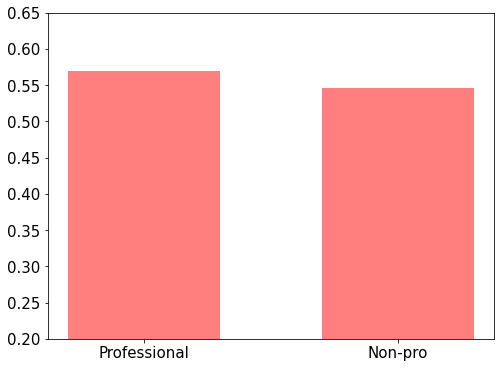

In [79]:
target_key = ["P","N"]
target_accuracy = []
for key in target_key:
    target_accuracy.append(sum(accuracy_by_meta[key])/len(accuracy_by_meta[key]))
target_accuracy

plt.figure(figsize=(8,6))
plt.bar(target_key, target_accuracy, color='red', alpha=0.5, width=0.6)
plt.xticks(target_key, ["Professional", "Non-pro"], fontsize=15)
plt.yticks(fontsize=15)
plt.ylim([0.2,0.65])

In [193]:
len(accuracy_by_song)
r5 = sum(1 for x in accuracy_by_song.values() if len(x)==5)
r4 = sum(1 for x in accuracy_by_song.values() if len(x)==4)
r3 = sum(1 for x in accuracy_by_song.values() if len(x)==3)
r2 = sum(1 for x in accuracy_by_song.values() if len(x)==2)
r1 = sum(1 for x in accuracy_by_song.values() if len(x)==1)
r1, r2, r3, r4, r5

(8, 9, 11, 10, 8)

In [182]:
top10_success

[(1, tensor(2124009)),
 (1, tensor(433855612)),
 (1, tensor(436055497)),
 (1, tensor(30477628)),
 (1, tensor(1692881)),
 (1, tensor(1692881)),
 (1, tensor(4847750)),
 (1, tensor(24134)),
 (1, tensor(424013762)),
 (1, tensor(24134)),
 (1, tensor(3773906)),
 (1, tensor(30477628)),
 (1, tensor(3773906)),
 (1, tensor(427182485)),
 (1, tensor(31296997)),
 (1, tensor(435437035)),
 (1, tensor(435279872)),
 (1, tensor(24134)),
 (1, tensor(427182485)),
 (1, tensor(3773906)),
 (1, tensor(435437035)),
 (1, tensor(24134)),
 (1, tensor(31296997)),
 (1, tensor(2124009)),
 (1, tensor(4847750)),
 (1, tensor(1692881)),
 (1, tensor(433855612)),
 (1, tensor(30477628)),
 (1, tensor(435279872)),
 (1, tensor(4847750)),
 (1, tensor(427182485)),
 (1, tensor(424013762)),
 (1, tensor(30477628)),
 (1, tensor(424013762)),
 (1, tensor(30477628)),
 (1, tensor(3773906)),
 (1, tensor(436055497)),
 (1, tensor(1692881)),
 (1, tensor(436055497)),
 (1, tensor(1692881))]

In [136]:
# total_instability = [cal_instability_of_contour(x['orig']) for x in humm_valid_loader.dataset.contours]

In [ ]:
test = [x['orig'].shape for x in humm_valid_loader.dataset.contours]

In [161]:
total_embs.shape

torch.Size([220891, 256])

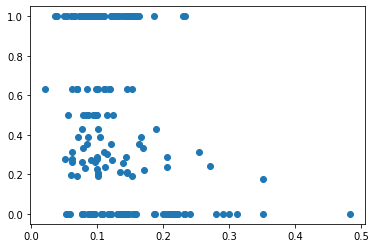

In [136]:
plt.scatter(total_instability, np.asarray(total_ndcg))

In [144]:
def plot_contour_with_voice_only(contour):
    dummy = np.copy(contour)
    dummy[contour[:,1]==0,0] = np.nan
    plt.plot(dummy[:,0])

In [158]:
threshold = 0.1
pair_db = humm_valid_loader.dataset.contours
for i, score in enumerate(total_ndcg):
    if score < threshold:
        sample = pair_db[i]
        humm_contour = sample['humm']
        orig_contour = sample['orig']
        humm_audio = generate_sine_wav(normalized_vec_to_orig(humm_contour), frame_rate=100)
        orig_contour_audio = generate_sine_wav(normalized_vec_to_orig(orig_contour), frame_rate=100)
        orig_audio = load_orig_audio_by_id(str(sample['meta']['track_id']))
        slice_pos = [int(x) for x in sample['meta']['time_stamp'].split('-')]
        orig_audio = orig_audio[slice_pos[0]*44100:slice_pos[1]*44100]
        
        top_rec = total_recommends[i]
        top_rec_contour_audio = generate_sine_wav(normalized_vec_to_orig(top_rec['contour']), frame_rate=100)
        top_rec_audio = load_orig_audio_by_id(str(top_rec['song_id']))
        top_rec_audio = top_rec_audio[top_rec['frame_pos'][0]*441:top_rec['frame_pos'][1]*441]
        
        fig = plt.figure(figsize=(15, 8))
        fig.tight_layout()
        plt.plot(humm_contour[:,0])
        plt.plot(orig_contour[:,0])
        plt.plot(top_rec['contour'][:,0])
        path = Path(sample["meta"]["pitch_path"])
        plt.savefig(f'valid_monitoring/{path.stem}_plot.png')
        plt.close(fig)
        
        fig2 = plt.figure(figsize=(15, 8))
        fig2.tight_layout()
        plot_contour_with_voice_only(humm_contour)
        plot_contour_with_voice_only(orig_contour)
        plot_contour_with_voice_only(top_rec['contour'])
        plt.savefig(f'valid_monitoring/{path.stem}_voice_only_plot.png')
        plt.close(fig2)

        soundfile.write(f'valid_monitoring/{i}_{Path(sample["meta"]["pitch_path"]).stem}_humming.wav', humm_audio, 44100)
        soundfile.write(f'valid_monitoring/{i}_{Path(sample["meta"]["pitch_path"]).stem}_orig_contour.wav', orig_contour_audio, 44100)
        soundfile.write(f'valid_monitoring/{i}_{Path(sample["meta"]["pitch_path"]).stem}_orig.wav', orig_audio, 44100)
        soundfile.write(f'valid_monitoring/{i}_{Path(sample["meta"]["pitch_path"]).stem}_orig_combined.wav', (orig_audio+orig_contour_audio)/2, 44100)
        soundfile.write(f'valid_monitoring/{i}_{Path(sample["meta"]["pitch_path"]).stem}_top_rec_contour.wav', top_rec_contour_audio, 44100)
        soundfile.write(f'valid_monitoring/{i}_{Path(sample["meta"]["pitch_path"]).stem}_top_rec.wav', top_rec_audio, 44100)


In [175]:
pair_db = humm_test_loader.dataset.contours
for i, sample in enumerate(pair_db):
    if sample['meta']['track_id'] in top_songs:
        humm_contour = sample['humm']
        orig_contour = sample['orig']
        humm_audio = generate_sine_wav(normalized_vec_to_orig(humm_contour), frame_rate=100)
        orig_contour_audio = generate_sine_wav(normalized_vec_to_orig(orig_contour), frame_rate=100)
        orig_audio = load_orig_audio_by_id(str(sample['meta']['track_id']))
        slice_pos = [int(x) for x in sample['meta']['time_stamp'].split('-')]
        orig_audio = orig_audio[slice_pos[0]*44100:slice_pos[1]*44100]
        
        top_rec = total_recommends[i]
        top_rec_contour_audio = generate_sine_wav(normalized_vec_to_orig(top_rec['contour']), frame_rate=100)
        top_rec_audio = load_orig_audio_by_id(str(top_rec['song_id']))
        top_rec_audio = top_rec_audio[top_rec['frame_pos'][0]*441:top_rec['frame_pos'][1]*441]
        
        fig = plt.figure(figsize=(15, 8))
        fig.tight_layout()
        plt.plot(humm_contour[:,0])
        plt.plot(orig_contour[:,0])
#         plt.plot(top_rec['contour'][:,0])
        path = Path(sample["meta"]["pitch_path"])
        plt.savefig(f'valid_monitoring/{path.stem}_plot.png')
        plt.close(fig)
        
        fig2 = plt.figure(figsize=(15, 8))
        fig2.tight_layout()
        plot_contour_with_voice_only(humm_contour)
        plot_contour_with_voice_only(orig_contour)
#         plot_contour_with_voice_only(top_rec['contour'])
        plt.savefig(f'valid_monitoring/{path.stem}_voice_only_plot.png')
        plt.close(fig2)

        copyfile(sample['meta']['path'], f'valid_monitoring/{Path(sample["meta"]["pitch_path"]).stem}_hum.wav')
        soundfile.write(f'valid_monitoring/{Path(sample["meta"]["pitch_path"]).stem}_humming.wav', humm_audio, 44100)
        soundfile.write(f'valid_monitoring/{Path(sample["meta"]["pitch_path"]).stem}_orig_contour.wav', orig_contour_audio, 44100)
        soundfile.write(f'valid_monitoring/{Path(sample["meta"]["pitch_path"]).stem}_orig.wav', orig_audio, 44100)
        soundfile.write(f'valid_monitoring/{Path(sample["meta"]["pitch_path"]).stem}_orig_combined.wav', (orig_audio+orig_contour_audio)/2, 44100)
#         soundfile.write(f'valid_monitoring/{i}_{Path(sample["meta"]["pitch_path"]).stem}_top_rec_contour.wav', top_rec_contour_audio, 44100)
#         soundfile.write(f'valid_monitoring/{i}_{Path(sample["meta"]["pitch_path"]).stem}_top_rec.wav', top_rec_audio, 44100)


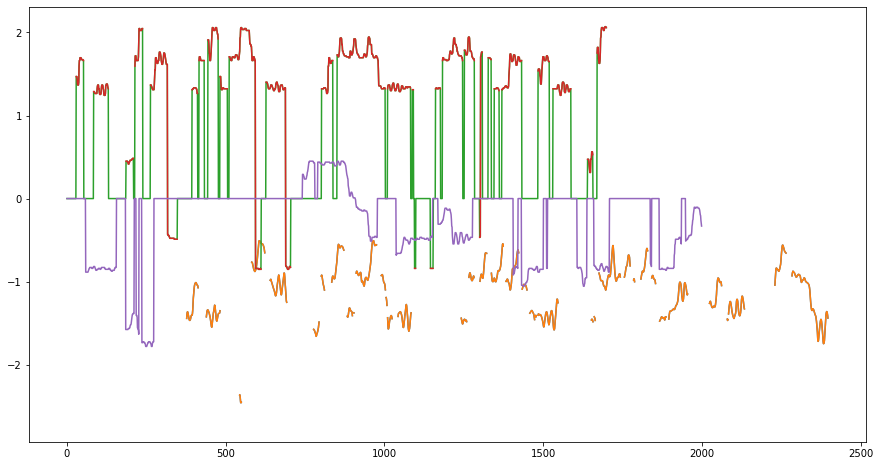

In [153]:
        fig = plt.figure(figsize=(15, 8))
        plt.plot(humm_contour[:,0])
        humm_contour[humm_contour[:,1]==0,0] = np.nan
        plt.plot(humm_contour[:,0])
    
        plt.plot(orig_contour[:,0])
        plot_contour_with_voice_only(orig_contour)
        plt.plot(top_rec['contour'][:,0])
        path = Path(sample["meta"]["pitch_path"])
#         plt.savefig(f'{path.stem}_plot.png')
#         plt.close(fig)

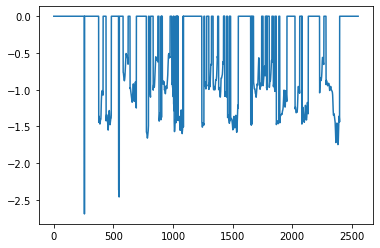

In [155]:
plt.plot(humm_contour[:,0])

In [8]:
[cal_ndcg_single(recommends[i,:], song_ids[i]) for i in range(recommends.shape[0])]

[0, 1.0, 1.0, 0, 0.24465054211822598, 1.0, 1.0, 1.0]

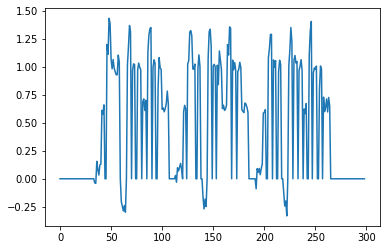

In [37]:
plt.plot(contours[2,:,0])

0 {'humm': array([[0., 0.],
       [0., 0.],
       [0., 0.],
       ...,
       [0., 0.],
       [0., 0.],
       [0., 0.]]), 'orig': array([[ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       ...,
       [-0.82920376,  1.        ],
       [-0.82920376,  1.        ],
       [-0.82920376,  1.        ]]), 'meta': {'path': '/home/svcapp/userdata/humming_db/100/50~74/01_P/100_71_A_15-34_(PM_JJH).wav', 'pitch_path': '/home/svcapp/userdata/humming_db/100/50~74/01_P/100_71_A_15-34_(PM_JJH).f0.csv', 'song_group': '100', 'song_idx': '71', 'humming_type': 'A', 'time_stamp': '15-34', 'singer_group': 'P', 'singer_id': 'JJH', 'singer_gender': 'M', 'track_id': 421127232}}


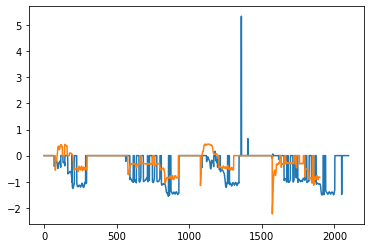

In [102]:
idx = 91
sample = humm_valid_loader.dataset.contours[idx]
plt.plot(sample['humm'][:,0])
plt.plot(sample['orig'][:,0])
print(total_ndcg[idx],sample)

In [56]:
humm_contour = sample['humm']
humm_audio = generate_sine_wav(normalized_vec_to_orig(humm_contour), frame_rate=100)
ipd.Audio(humm_audio, rate=44100)

In [55]:
humm_contour.shape

(2100,)

In [57]:
humm_contour = sample['orig']
humm_audio = generate_sine_wav(normalized_vec_to_orig(humm_contour), frame_rate=100)
ipd.Audio(humm_audio, rate=44100)

In [74]:
valid_batch = next(iter(valid_loader))
with torch.no_grad():
    valid_batch = valid_batch[0].cuda()
    valid_emb = model(valid_batch)

In [77]:
valid_emb.shape

torch.Size([256, 256])

In [73]:
anchor.shape

torch.Size([24, 1, 256])

In [ ]:
neg.shape

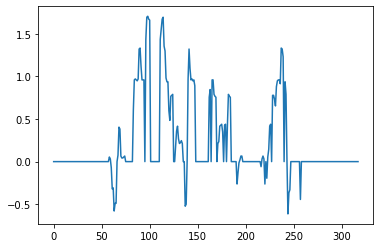

In [93]:
batch_np = batch.cpu().view([-1, 1+hparams.num_pos_samples + hparams.num_neg_samples, batch.shape[1], batch.shape[-1]]).numpy()
# for i in range(batch_np.shape[0]):
plt.plot(batch_np[10,0,:,0])
# plt.plot(batch_np[10,1,:,0])

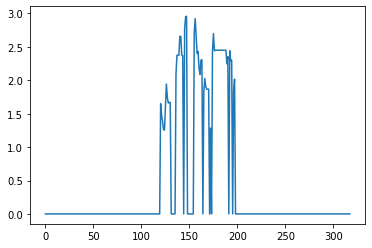

In [95]:
plt.plot(batch_np[10,2,:,0])

In [ ]:
criterion.similiarity_fn(anchor, neg)

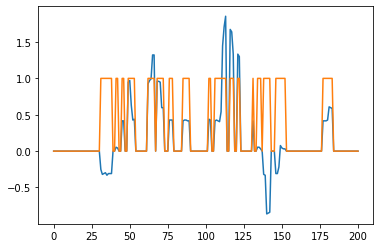

In [16]:
plt.plot(train_loader.dataset[1000][0])

In [98]:
embed_cat = torch.cat([anchor, pos, neg], dim=1).view(-1, anchor.shape[-1])
humm_embed = torch.cat([humm_anchor, humm_pos, humm_neg], dim=1).view(-1, anchor.shape[-1])
embed_cat = torch.cat([embed_cat, humm_embed, valid_emb], dim=0)
anchor_embedded = TSNE(n_components=2).fit_transform(embed_cat.squeeze().cpu().numpy())

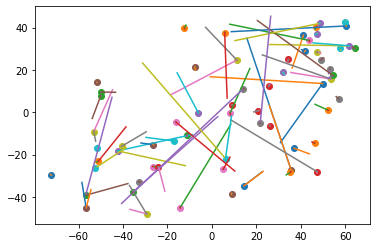

In [88]:
num_emb_per_melody = 1+hparams.num_pos_samples + hparams.num_neg_samples
for i in range(anchor.shape[0]):
    anchor_id = i*num_emb_per_melody
    plt.scatter(anchor_embedded[anchor_id,0], anchor_embedded[anchor_id,1])
    for j in range(hparams.num_pos_samples):
        plt.plot( [anchor_embedded[anchor_id,0], anchor_embedded[anchor_id+j+1,0]], [anchor_embedded[anchor_id,1], anchor_embedded[anchor_id+j+1,1]] )

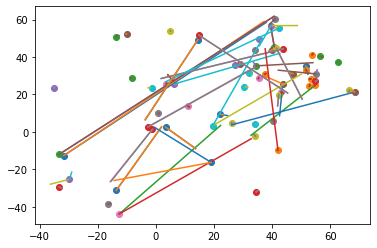

In [91]:
for i in range(humm_anchor.shape[0]):
    anchor_id = i*num_emb_per_melody+batch.shape[0]
    plt.scatter(anchor_embedded[anchor_id,0], anchor_embedded[anchor_id,1])
    for j in range(hparams.num_pos_samples):
        plt.plot( [anchor_embedded[anchor_id,0], anchor_embedded[anchor_id+j+1,0]], [anchor_embedded[anchor_id,1], anchor_embedded[anchor_id+j+1,1]] )

In [90]:
batch.shape[0]

448

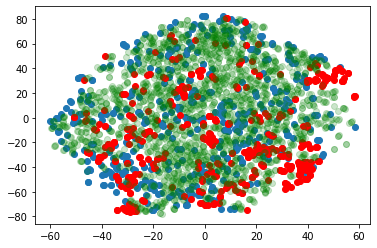

In [99]:
plt.scatter(anchor_embedded[:batch.shape[0],0], anchor_embedded[:batch.shape[0],1])
plt.scatter(anchor_embedded[batch.shape[0]:batch.shape[0]*2,0], anchor_embedded[batch.shape[0]:batch.shape[0]*2,1], color='red')
plt.scatter(anchor_embedded[batch.shape[0]*2:,0], anchor_embedded[batch.shape[0]*2:,1], color='green', alpha=0.2)

In [59]:
plt.scatter(anchor_embedded[:batch.shape[0],0], anchor_embedded[:batch.shape[0],1])


(168, 2)

In [61]:
humm_batch.shape

torch.Size([168, 539, 2])